In [1]:
import torch
import PIL
print(PIL.__version__)
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import glob
import os
import numpy as np
import sys
print(sys.version)

4.3.0
3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 13:26:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [4]:
path='/home/are/data_cervical/pytorch_running/3_data/'
files=glob.glob(os.path.join(path,'*/*.jpg'))
no_of_files=len(files)
print(len(files))
shuffle=np.random.permutation(no_of_files)
valid_num=int(no_of_files/5)
for i in shuffle[:valid_num]:
    folder=files[i].split('/')[-2]
    
    image=files[i].split('/')[-1]
    
    
    os.rename(files[i],os.path.join(path,'valid',folder,image))
for i in shuffle[valid_num:]:
    folder=files[i].split('/')[-2]
    
    image=files[i].split('/')[-1]
    
    
    os.rename(files[i],os.path.join(path,'train',folder,image))

0


In [2]:
transform = transforms.Compose(
    [transforms.Resize((224,224)),transforms.ToTensor(),
     transforms.Normalize((0.5941, 0.3818, 0.3370), ((0.1508 ,0.1404, 0.1222)))])
train_dataset=torchvision.datasets.ImageFolder('/home/are/data_cervical/pytorch_running/3_data/caijian2/train/',transform)
valid_dataset=torchvision.datasets.ImageFolder('/home/are/data_cervical/pytorch_running/3_data/caijian2/valid/',transform)

In [3]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=6)
valid_loader=torch.utils.data.DataLoader(valid_dataset,batch_size=32,shuffle=True,num_workers=6)

In [4]:
model_ft=models.resnet50(pretrained=True)
#print(model_ft)
num_ftrs=model_ft.fc.in_features
model_ft.fc=nn.Linear(num_ftrs,3)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft=model_ft.to(device)
print(model_ft)
#现在不叫迁移学习，迁移学习要固定前面的参数
print(model_ft.layer4.parameters())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [5]:
for param in model_ft.conv1.parameters():
    param.requires_grad=False
for param in model_ft.bn1.parameters():
    param.requires_grad=False
for param in model_ft.relu.parameters():
    param.requires_grad=False
for param in model_ft.maxpool.parameters():
    param.requires_grad=False
for param in model_ft.layer1.parameters():
    
    param.requires_grad=False
for param in model_ft.layer2.parameters():
    param.requires_grad=False
for param in model_ft.layer3.parameters():
    param.requires_grad=False

In [6]:
learning_rate=0.001
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model_ft.layer4.parameters(),weight_decay=1e-4,lr=0.001)
exp_lr_scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=20)


In [8]:
import time
dataloader={'train':train_loader,'valid':valid_loader}
dataset={'train':train_dataset,'valid':valid_dataset}
best_model_wts=model_ft.state_dict()
best_acc=0.0
num_epochs=80
train_loss=[]
train_acc=[]
valid_loss=[]
valid_acc=[]
times=[]
for epoch in range(num_epochs):
    since=time.time()
    print('epoch:',epoch)
    print('-'*10)
        
    for phase in ['train','valid']:
            
        if phase=='train':
            model_ft.train(True)
        else:
            model_ft.train(False)
        running_loss=0.0
        running_corrects=0
        
        for i, data in enumerate(dataloader[phase], 0):
                
            inputs, labels = data
            inputs=torch.autograd.Variable(inputs.to(device))  #数据和标签要放到GPU上
            labels=torch.autograd.Variable(labels.to(device))
                
            optimizer.zero_grad()
                # forward + backward + optimize
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)
            _,preds=torch.max(outputs.data,1)
            if phase=='train':
                loss.backward()
                optimizer.step()
            running_loss+=loss.item()
            running_corrects+=(torch.sum(preds==labels.data)).item()
        print(running_loss)
        print(running_corrects)
       
           
        print(len(dataset[phase]))
        epoch_loss=running_loss/len(dataset[phase])
            #epoch_loss=running_loss/4463
        epoch_acc=running_corrects/len(dataset[phase])
        if phase=='train':
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            valid_loss.append(epoch_loss)
            valid_acc.append(epoch_acc)
        print('{} loss: {:.4f} acc:{:.4f}'.format(phase,epoch_loss,epoch_acc))
        if phase=='valid' and epoch_acc>best_acc:
            best_acc=epoch_acc
            best_model_wts=model_ft.state_dict()
    time_elapsed= time.time()-since
    times.append(time_elapsed)
    print('training time:',time_elapsed)
model_ft.load_state_dict(best_model_wts)


epoch: 0
----------
437.8373104929924
11524
17780
train loss: 0.0246 acc:0.6481
107.92394655942917
2911
4444
valid loss: 0.0243 acc:0.6550
training time: 44.47669577598572
epoch: 1
----------
357.68841338157654
12919
17780
train loss: 0.0201 acc:0.7266
98.43422695994377
3041
4444
valid loss: 0.0221 acc:0.6843
training time: 45.133776903152466
epoch: 2
----------
252.55085743963718
14480
17780
train loss: 0.0142 acc:0.8144
88.93719977140427
3276
4444
valid loss: 0.0200 acc:0.7372
training time: 44.88419508934021
epoch: 3
----------
138.83226113766432
16094
17780
train loss: 0.0078 acc:0.9052
107.65590432286263
3266
4444
valid loss: 0.0242 acc:0.7349
training time: 45.978129863739014
epoch: 4
----------
83.3563969694078
16826
17780
train loss: 0.0047 acc:0.9463
143.26379802823067
3188
4444
valid loss: 0.0322 acc:0.7174
training time: 45.57917308807373
epoch: 5
----------
66.96656491234899
17005
17780
train loss: 0.0038 acc:0.9564
104.17658895254135
3319
4444
valid loss: 0.0234 acc:0.7468

145.16954854130745
3244
4444
valid loss: 0.0327 acc:0.7300
training time: 45.70894765853882
epoch: 48
----------
22.83244583941996
17552
17780
train loss: 0.0013 acc:0.9872
121.26161076128483
3325
4444
valid loss: 0.0273 acc:0.7482
training time: 45.04698634147644
epoch: 49
----------
18.43258698657155
17598
17780
train loss: 0.0010 acc:0.9898
122.05746901035309
3300
4444
valid loss: 0.0275 acc:0.7426
training time: 45.37336206436157
epoch: 50
----------
23.487902585417032
17532
17780
train loss: 0.0013 acc:0.9861
131.4427441060543
3331
4444
valid loss: 0.0296 acc:0.7495
training time: 45.66536593437195
epoch: 51
----------
22.73220843821764
17524
17780
train loss: 0.0013 acc:0.9856
151.2929833829403
3324
4444
valid loss: 0.0340 acc:0.7480
training time: 45.05977010726929
epoch: 52
----------
18.86821240745485
17586
17780
train loss: 0.0011 acc:0.9891
134.0302310883999
3279
4444
valid loss: 0.0302 acc:0.7378
training time: 45.823328256607056
epoch: 53
----------
22.571025640470907
1753

In [10]:
save_path='/home/are/data_cervical/pytorch_running/third/resnet50_finetuning'
torch.save(model_ft,os.path.join(save_path,'resnet50.pth'))

Populating the interactive namespace from numpy and matplotlib


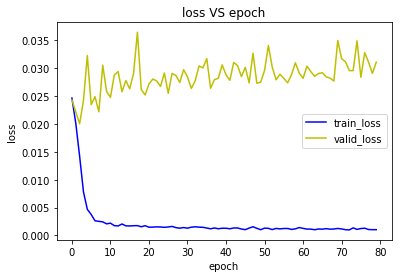

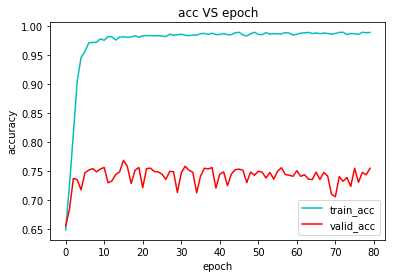

In [11]:
import matplotlib.pyplot as plt
%pylab inline
x1=range(0,num_epochs)
x2=range(0,num_epochs)
y1=train_loss
y2=train_acc
y3=valid_acc
y4=valid_loss
plt.title('loss VS epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(x1,y1,'b',label='train_loss')
plt.plot(x1,y4,'y',label='valid_loss')
plt.legend()#显示label
plt.savefig(os.path.join(save_path,'1.jpg'))
plt.show()  #一定要在show之前保存

plt.title('acc VS epoch')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(x2,y2,'c',label='train_acc')
plt.plot(x2,y3,'r',label='valid_acc')
plt.legend()#显示label
plt.savefig(os.path.join(save_path,'2.jpg'))
plt.show()



In [12]:
with open(os.path.join(save_path,'train_loss.txt'),'w') as f:
    for line in train_loss:
        f.write(str(line)+'\n')
with open(os.path.join(save_path,'train_acc.txt'),'w') as f:
    for line in train_acc:
        f.write(str(line)+'\n')

with open(os.path.join(save_path,'valid_acc.txt'),'w') as f:
    for line in valid_acc:
        f.write(str(line)+'\n')
with open(os.path.join(save_path,'time.txt'),'w') as f:
    for line in times:
        f.write(str(line)+'\n')
       

In [ ]:
model=torch.load('/home/are/data_cervical/pytorch_running/second/resnet50_batch32/resnet50.pth')
running_corrects=0
for i, data in enumerate(dataloader['train'], 0):
    inputs, labels = data
    inputs=torch.autograd.Variable(inputs.to(device))  #数据和标签要放到GPU上
    labels=torch.autograd.Variable(labels.to(device))
                
            #optimizer.zero_grad()
                # forward + backward + optimize
    outputs = model(inputs)
    #loss = criterion(outputs, labels)
                #print(loss)
    _,preds=torch.max(outputs.data,1)
    running_corrects+=(torch.sum(preds==labels.data)).item()
epoch_acc=running_corrects/len(dataset['train'])
print(running_corrects)
print(len(dataset['train']))
print(epoch_acc)                           